In [4]:
from SALib.sample import latin, sobol
import pandas as pd
import numpy as np

### Sampling

##### 1. Model inputs

In [2]:
# Number of Samples
nsamples = 100 

# Number of parameters
nparams = 8 

#Ranges for each parameter
param_ranges = {
    'cell_ecm_repulsion': [0, 75],
    'contact_cell_ECM_threshold': [0, 2],
    'contact_cell_cell_threshold': [0, 3.5],
    'cell_junctions_attach_threshold': [0, 1],
    'cell_junctions_detach_threshold': [0, 1],
    'migration_bias': [0, 1],
    'migration_speed': [0, 1],
    'persistence': [0, 100]
}

#Define the problem for SALib
problem = {
    'num_vars': nparams,
    'names': list(param_ranges.keys()),
    'bounds': [[0, 75], [0, 2], [0, 3.5], [0, 1], [0, 1], [0, 1], [0, 1], [0, 100]] 
}

##### 2. Generate samples

In [3]:
#Generate Latin hypercube samples
lhs_samples = latin.sample(problem, nsamples)
#Generate sobol samples
sobol_samples = sobol.sample(problem, nsamples)

/home/marcelo/mambaforge/lib/python3.10/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


##### 3. Save output 

In [4]:
param_names = list(param_ranges.keys())
lhs_samples = pd.DataFrame(lhs_samples, columns=param_names)
sobol_samples = pd.DataFrame(sobol_samples, columns=param_names)

#Save output
lhs_samples.to_csv('lhs_samples.csv', index=False)
sobol_samples.to_csv('sobol_samples.csv', index=False)

##### 4. Generate subspace

In [5]:
data = pd.read_csv('lhs_samples.csv')
num_files = 4
rows = int(len(data)/num_files)

# Loop over the number of output files to generate
for i in range(num_files):
    # Calculate the start and end indices for the current output file
    start_idx = i * rows
    end_idx = (i + 1) * rows

    # If this is the last file, include any remaining rows
    if i == num_files - 1:
        end_idx = len(data)

    # Extract the rows for the current output file
    subset = data.iloc[start_idx:end_idx]

    # Write the rows to a new CSV file
    filename = f'saltelli_samples_{i}.csv'
    subset.to_csv(filename, index=False)

### Parse XML

In [7]:
import xml.etree.ElementTree as ET
import subprocess

##### Load files

In [8]:
#Load samples from LHS or Sobol
samples_lhs = pd.read_csv('../data_output/lhs_samples.csv')
#samples_sobol = pd.read_csv('sobol_samples.csv')
#Load xml file
tree = ET.parse('../output/NLC_CLL.xml')
root = tree.getroot()

##### Parameters

In [7]:
#param_names = {"cell_cell_repulsion_strength": 0, "cell_cell_adhesion_strength": 1, "relative_maximum_adhesion_distance": 2, 
#               "cell_BM_adhesion_strength": 3, "speed": 4, "migration_bias": 5, "secretion_rate": 6, "fluid_change_rate":7}
param_names = {"cell_cell_repulsion_strength": 0, "cell_cell_adhesion_strength": 1}


In [14]:
samples_lhs = np.loadtxt('../data_output/lhs_samples.csv', delimiter=",", skiprows=1)
param_names = {"cell_cell_repulsion_strength": 0, "cell_cell_adhesion_strength": 1}

replicates = 2 #For bootstrapping
# Loop over each iteration in the LHS data
for i, lhs_iteration in enumerate(samples_lhs): #Taking rows where i = row number and lhs_iteration = list of parameters from corresponding row
# Loop over each parameter and update its value in the XML file
    for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number
        param_value = lhs_iteration[lhs_col_index] #Extract each value [i, lhs_col_index]
        param_element = root.find(f".//{param_name}") #Find the param name in XML file
        param_element.text = str(param_value) #Update the text of xml file with extracted value 
        print(param_value)
    # Write the updated XML to a string
    #updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")
    print("Hola")

    for i in range(replicates):
        print(i)

    # Define the command to call your C++ software with the updated XML as input
    #command = ["./project", "./config/NLC_CLL.xml"]
    #stdin_str = updated_xml_str

    #for i in range(replicates): #replicates is for bootstrapping, we run the simulation with updated value # (replicates) times
        # Call the C++ software using subprocess


6.77207015211592
0.33581892671335156
Hola
0
1
3.5120965462638227
0.5546229127400352
Hola
0
1
7.284917813716587
0.08014615605434612
Hola
0
1


In [27]:
for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number
    param_value = samples_lhs.iloc[2,:].values[lhs_col_index] #Extract each value [i, lhs_col_index]
    param_element = root.find(f".//{param_name}") #Find the param name in XML file
    print(param_element.text)
    param_element.text = str(param_value) #Update the text of xml file with extracted value 
    print(param_element.text)

# Write the updated XML to a string
updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")

10.0
8.312551285070388
0.4
0.0154421115384104


##### Loop to update values in XML file

In [28]:
replicates = 5 #For bootstrapping
# Loop over each iteration in the LHS data
for i, lhs_iteration in enumerate(samples_lhs): #Taking rows where i = row number and lhs_iteration = list of parameters from corresponding row
# Loop over each parameter and update its value in the XML file
    for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number
        param_value = lhs_iteration[lhs_col_index] #Extract each value [i, lhs_col_index]
        param_element = root.find(f".//{param_name}") #Find the param name in XML file
        param_element.text = str(param_value) #Update the text of xml file with extracted value 
        
    #To fix: root.find is not finding all elements that match with param_name, only is replacing in the first one
    #if updated_xml_str is outside this for is because all the set of input variables are being replacing in the xml file at once
        
    # Write the updated XML to a string
    updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")

    # Define the command to call your C++ software with the updated XML as input
    command = ["./project", "./config/NLC_CLL.xml"]
    stdin_str = updated_xml_str

    for i in range(replicates): #replicates is for bootstrapping, we run the simulation with updated value # (replicates) times
        # Call the C++ software using subprocess
        proc = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = proc.communicate(stdin_str.encode())

        # Check that the Physicell ran successfully
        if proc.returncode != 0:
            print(f"Error running Physicell for iteration {i}")
            print(stderr.decode())
            continue

        subprocess.run(["python", "collect_data.py"]) #We collect the data at each iteration

    subprocess.run(["python", "merge_data.py"]) #Merge data of replicates 
    print("Next set") #Continue to next row 

0
[4.10974114e+01 1.47633341e+00 3.01578266e+00 9.76567846e-01
 4.00375456e-01 5.07515288e-01 6.60809929e-02 7.87298251e+01]
1
[67.86096356  1.67010491  1.69111209  0.21323608  0.98205021  0.63047726
  0.64093937 30.72880196]
2
[6.86187986e+01 1.11231067e+00 1.99026535e+00 5.38374681e-01
 1.65846992e-02 4.89767979e-01 3.87244318e-01 9.38769127e+01]
3
[2.16736882e+01 3.51305485e-01 2.58229527e+00 2.64745557e-02
 1.47323109e-01 6.21531454e-01 8.85581957e-01 6.15764758e+01]
4
[ 1.51842502  1.99941032  2.72376401  0.98903601  0.23911252  0.56817093
  0.46063593 43.72149055]
5
[19.54229177  1.136348    2.42279078  0.5080213   0.07811851  0.71662204
  0.96575345 52.90755934]
6
[65.62297919  1.97045892  3.28400678  0.88823513  0.78263064  0.20167301
  0.11409374 15.1987578 ]
7
[35.42804106  1.40139893  0.05451966  0.92362613  0.09996595  0.23130597
  0.7935656  54.10819012]
8
[11.24561025  0.2024214   0.78816775  0.59885751  0.05071892  0.55126828
  0.34152582 28.33031504]
9
[6.41267448e+01 1

'   # Loop over each parameter and update its value in the XML file\n    for param_name, lhs_col_index in param_names.items(): # param_name = parameter name and lhs_col_index = column number\n        param_value = lhs_iteration[lhs_col_index]\n        param_xpath = f".//{param_name}/text()"\n        param_element = root.find(param_xpath)\n        param_element.text = str(param_value)\n\n    # Write the updated XML to a string\n    updated_xml_str = ET.tostring(root, encoding="unicode", method="xml")\n\n    # Define the command to call your C++ software with the updated XML as input\n    command = ["./Invasion_model", "./config/PhysiCell_settings_2D.xml"]\n    stdin_str = updated_xml_str\n    for i in range(replicates):\n        # Call the C++ software using subprocess\n        proc = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)\n        stdout, stderr = proc.communicate(stdin_str.encode())\n\n        # Check that the C++ software comp

### Collect data

In [18]:
import anndata as ad  
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pcdl
import os

In [10]:
dir_output = 'output'
mcdsts = pcdl.TimeSeries(dir_output) 
timesteps = mcdsts.get_mcds_list()

reading: output/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: output/output00000000.xml
working on metadata ...
working on mesh data ...
reading: output/initial_mesh0.mat
working on microenvironment data ...
reading: output/output00000000_microenvironment0.mat
parsing: anti-apoptotic_factor data
parsing: debris data
working on discrete cell data ...
reading: output/output00000000_cells.mat
working on graph data ...
reading: output/output00000000_cell_neighbor_graph.txt
reading: output/output00000000_attached_cells_graph.txt
done!

reading: output/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['sample']
reading: output/output00000001.xml
working on metadata ...
working on mesh data ...
reading: output/initial_mesh0.mat
working on microenvironment data ...
reading: output/output00000001_microenvironment0.mat
parsing: anti-

#### Viability

In [11]:
#Extract positions corresponding to days 1-13
positions = []
for days in range(0,14):
    hours = 24*days
    positions.append(hours)

#Initial CLL cells
initial = timesteps[0].get_cell_df(states=2)
CLL_initial = len(initial[(initial['cell_type']=="cancer_cells")|(initial['cell_type']=="apoptotic")])

#Calculate alive and dead cells across days
alive = [CLL_initial]
dead = [0]
for i in range(1, len(positions)):
  step = timesteps[positions[i]].get_cell_df(states=2)
  number_alive = len(step[((step['cell_type']=='cancer_cells')|(step['cell_type']=='apoptotic'))&(step['dead']==False)])
  number_dead = len(step[step['dead']==True])
  alive.append(number_alive)
  dead.append(number_dead)

CLL_alive = pd.Series(alive, name="Cells_alive")
CLL_dead = pd.Series(dead, name = "Cells_dead")

#Calculate viability =  CLL alive / (CLL alive + CLL dead)
viability = []
for i in range(len(CLL_alive)):
    number = (CLL_alive[i]/(CLL_alive[i]+CLL_dead[i]))*100
    viability.append(number)

viability = pd.Series(viability, name = "CLL viability")

#### Concentration

In [12]:
#Cells alive / Volume
volumen = 0.0000648 #cm3 648x10**-7

concentration = []
for i in CLL_alive:
    number = round(i/volumen,2)*100
    concentration.append(number)

concentration = pd.Series(concentration, name = "CLL concentration")

#### Save data

In [17]:
df = pd.concat([viability, concentration], axis=1)

file_csv = 'data.csv'

#If the file already exists
if os.path.exists(file_csv):
    old_data = pd.read_csv(file_csv)
    new_data = pd.concat([old_data, df], axis=1)
    new_data.to_csv(file_csv, index=False, header=True)
else:
    df.to_csv(file_csv, index=False, header=True)

#### Merge data

In [24]:
import pandas as pd

df = pd.read_csv('data.csv')

# Calculate the column-wise median
num_lis = []
for i in range(1, df.shape[1],2):
    number = df.iloc[:, i]
    num_lis.append(number)
    
num_lis = pd.DataFrame(num_lis)
medians = num_lis.median()

# Create a new DataFrame with the averages
viability = pd.DataFrame(medians)
viability_csv = 'viability.csv'

# Calculate the column-wise median
num_lis = []
for i in range(2, df.shape[1],2):
    number = df.iloc[:, i]
    num_lis.append(number)
    
num_lis = pd.DataFrame(num_lis)
medians = num_lis.median()

# Create a new DataFrame with the averages
concentration = pd.DataFrame(medians)
concentration_csv = 'concentration.csv'


#### SA analysis

In [29]:
import pandas as pd
import numpy as np

##### Problem

In [74]:
# Number of parameters
nparams = 2 

#Ranges for each parameter
param_ranges = {
    'cell_cell_repulsion_strength': [1, 10],
    'cell_cell_adhesion_strength': [0, 0.6]
}

#Define the problem for SALib
problem = {
    'num_vars': nparams,
    'names': list(param_ranges.keys()),
    'bounds': [[1, 10], [0, 0.6]] 
}

In [88]:
#Samples
samples_sobol = np.loadtxt('../data_output/sobol_samples.csv', delimiter=",", skiprows=1)

#Read output of simulation
output = np.loadtxt('../data_output/viability.csv', delimiter=",", skiprows=1)

In [91]:
output_median = np.median(output, axis=0)

In [77]:
print(samples_sobol.shape)
print(output_median.shape)

(48, 2)
(48,)


In [86]:
# Sobol analysis
from SALib.analyze import sobol
Si = sobol.analyze(problem, output_median, print_to_console=True, calc_second_order=True) 

ValueError: could not broadcast input array from shape (8,4) into shape (32,)

In [85]:
print('Sobol Analysis Results:')
for i, param in enumerate(problem['names']):
   print(f"{param}: S1={Si['S1'][i]:.3f}, ST={Si['ST'][i]:.3f}")

Sobol Analysis Results:
cell_cell_repulsion_strength: S1=-0.059, ST=1.158
cell_cell_adhesion_strength: S1=0.179, ST=1.026


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

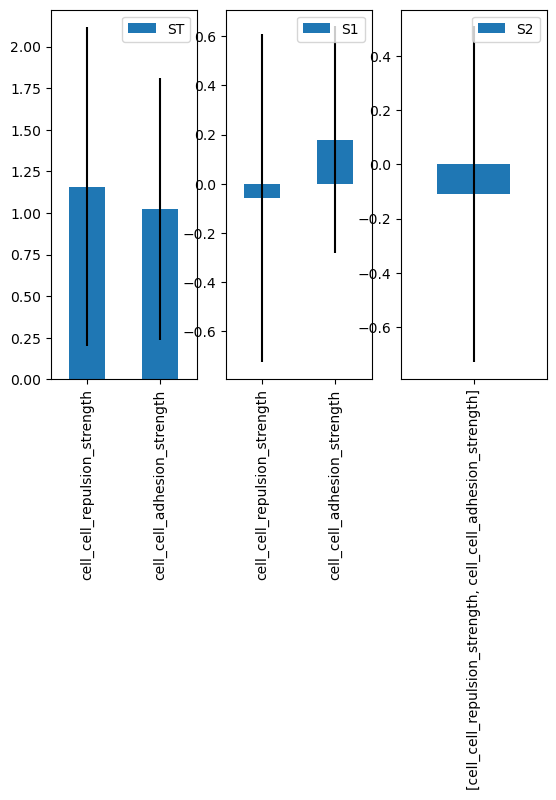

In [79]:
import matplotlib.pyplot as plt

axes = Si.plot()
axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
fig.set_size_inches(10, 4)
plt.tight_layout()